# Lung Segmentation


## import all packages

https://github.com/nikhilroxtomar/Unet-with-Pretrained-Encoder/blob/master/U-Net_with_Pretrained_MobileNetV2_as_Encoder.ipynb?ref=morioh.com&utm_source=morioh.com

In [1]:
import os
import datetime
import time
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization,MaxPooling2D,Dense,concatenate
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate,Conv2DTranspose
from tensorflow.keras.layers import Input,UpSampling3D,Dense, Dropout,BatchNormalization, Activation
from tensorflow.keras.layers import GlobalAveragePooling2D, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint,LearningRateScheduler
from tensorflow.keras.metrics import Recall, Precision,MeanIoU,AUC
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model



/Users/user/miniforge3/envs/Apple/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
IMAGE_SIZE = 256
EPOCHS = 50
BATCH = 4
LR = 1e-4

PATH = './dataset/LSP/train/'

# Load dataset

In [23]:
def load_data(path='../dataset/LSP/train/', split=0.1,mode=''):
    images = sorted(glob(os.path.join(path, "images/*")))
    masks = sorted(glob(os.path.join(path, "masks/*")))
    
    if mode == 'training':
        total_size = len(images)
        valid_size = int(split * total_size)
        train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
        train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

        return (train_x, train_y), (valid_x, valid_y)
    
    if mode == 'testing':
        return (images,masks)

In [5]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (256, 256))
    x = x/255.0
    x = np.expand_dims(x, axis=-1)
    return x

In [6]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([256, 256, 1])
    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
#     dataset = dataset.repeat()
    return dataset


In [7]:
(train_x, train_y), (valid_x, valid_y) = load_data(PATH,mode='training')

print("Training data: ", len(train_x))
print("Validation data: ", len(valid_x))


Training data:  1359
Validation data:  150


In [8]:
def read_and_rgb(x):
    x = cv2.imread(x)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    return x

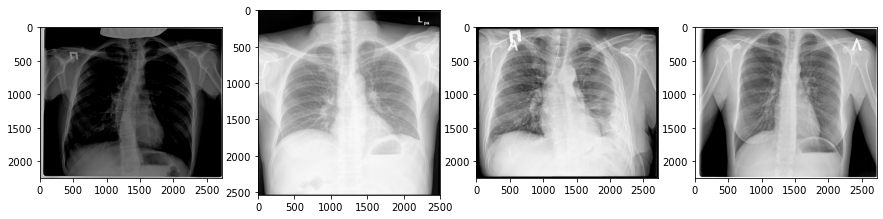

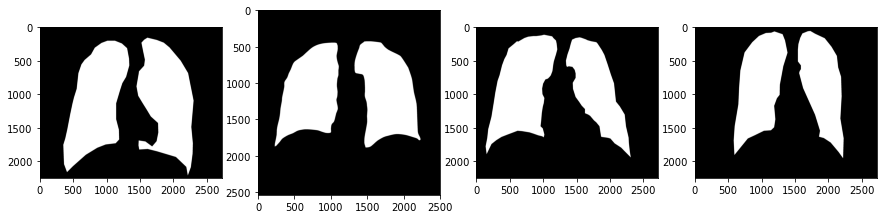

In [9]:
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(valid_x[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(valid_x[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(valid_x[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(valid_x[3]))
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(valid_y[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(valid_y[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(valid_y[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(valid_y[3]))
imgplot.set_clim(0.0, 1.4)

In [10]:
def build_model(inputs):
    mobilenetv2 = tf.keras.applications.MobileNetV2(
        input_tensor = inputs, 
        weights="imagenet", include_top=False, alpha=0.35)
    mobilenetv2.trainable = False
    x = mobilenetv2.get_layer('out_relu').output
    x = Conv2D(128,3,name='final_conv',padding='same',activation='relu')(x)
    x = GlobalAveragePooling2D(name='gap')(x)
    output = Dense(2,activation='sigmoid')(x)
    return tf.keras.Model(inputs,output)


In [38]:
def model():
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
    
    encoder = build_model(inputs)
#     encoder.load_weights('../../output/checkpoints/mobilenetv2/512_128weights.16-0.31.hdf5')
    skip_connection_names = ["input_image","block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    f = [ 16, 32, 48, 64]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs, x)
    
    return model

In [39]:
model = model()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 128, 16) 432         input_image[0][0]                
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 128, 128, 16) 64          Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 128, 128, 16) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [96]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def jackard_index(y_true, y_pred):
    
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) -intersection + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [42]:
train_dataset = tf_dataset(train_x, train_y, batch=BATCH)
valid_dataset = tf_dataset(valid_x, valid_y, batch=BATCH)


In [47]:
opt = tf.keras.optimizers.Nadam(LR)
metrics = [dice_coef, jackard_index, AUC(curve='PR'), Recall(), Precision()]
model.load_weights('./output/unet_weights.17.0.04.hdf5')
model.compile(loss = dice_loss, optimizer=opt, metrics=metrics)


In [16]:
log_dir = "logs/unet/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3),
    tf.keras.callbacks.TensorBoard(log_dir=log_dir),
    ModelCheckpoint(
        './output/unet_weights.{epoch:02d}.{val_loss:.2f}.hdf5',
        monitor='val_loss',save_best_only=True,save_weights_only=True,verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

2022-08-17 10:01:05.719288: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-08-17 10:01:05.719297: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-08-17 10:01:05.719640: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


In [17]:
train_steps = len(train_x)//BATCH
valid_steps = len(valid_x)//BATCH

if len(train_x) % BATCH != 0:
    train_steps += 1
if len(valid_x) % BATCH != 0:
    valid_steps += 1

model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

/Users/user/miniforge3/envs/Apple/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
2022-08-17 10:01:05.963072: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-08-17 10:01:05.963181: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/50


2022-08-17 10:01:07.117196: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


  1/340 [..............................] - ETA: 15:52 - loss: 0.6041 - dice_coef: 0.3959 - mean_io_u: 0.3428 - auc: 0.3201 - recall: 0.5492 - precision: 0.3419

2022-08-17 10:01:08.834100: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-08-17 10:01:08.834115: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.


  2/340 [..............................] - ETA: 5:04 - loss: 0.5929 - dice_coef: 0.4071 - mean_io_u: 0.3411 - auc: 0.3393 - recall: 0.5802 - precision: 0.3548 

2022-08-17 10:01:09.677444: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-08-17 10:01:09.682675: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-08-17 10:01:09.687551: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/unet/20220817-100105/train/plugins/profile/2022_08_17_10_01_09
2022-08-17 10:01:09.690404: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/unet/20220817-100105/train/plugins/profile/2022_08_17_10_01_09/users-MacBook-Pro.local.trace.json.gz
2022-08-17 10:01:09.694210: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/unet/20220817-100105/train/plugins/profile/2022_08_17_10_01_09
2022-08-17 10:01:09.694397: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to logs/unet/20220817-100105/train/plugins/

340/340 [==============================] - ETA: 0s - loss: 0.2408 - dice_coef: 0.7593 - mean_io_u: 0.3449 - auc: 0.9741 - recall: 0.9653 - precision: 0.8561

2022-08-17 10:06:27.945540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


340/340 [==============================] - 353s 1s/step - loss: 0.2408 - dice_coef: 0.7593 - mean_io_u: 0.3449 - auc: 0.9741 - recall: 0.9653 - precision: 0.8561 - val_loss: 0.2134 - val_dice_coef: 0.7863 - val_mean_io_u: 0.3489 - val_auc: 0.9893 - val_recall: 0.9886 - val_precision: 0.8830

Epoch 00001: val_loss improved from inf to 0.21337, saving model to ./output/unet_weights.01.0.21.hdf5
Epoch 2/50
340/340 [==============================] - 355s 1s/step - loss: 0.1662 - dice_coef: 0.8339 - mean_io_u: 0.3449 - auc: 0.9831 - recall: 0.9782 - precision: 0.9351 - val_loss: 0.1611 - val_dice_coef: 0.8385 - val_mean_io_u: 0.3489 - val_auc: 0.9871 - val_recall: 0.9799 - val_precision: 0.9317

Epoch 00002: val_loss improved from 0.21337 to 0.16115, saving model to ./output/unet_weights.02.0.16.hdf5
Epoch 3/50
340/340 [==============================] - 351s 1s/step - loss: 0.1333 - dice_coef: 0.8667 - mean_io_u: 0.3449 - auc: 0.9826 - recall: 0.9766 - precision: 0.9491 - val_loss: 0.1290 -

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Discarded (victim of GPU error/recovery) (00000005:kIOGPUCommandBufferCallbackErrorInnocentVictim)
	<AGXG13GFamilyCommandBuffer: 0x2ec550f00>
    label = <none> 
    device = <AGXG13GDevice: 0x15fcd6800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x1208d4e00>
        label = <none> 
        device = <AGXG13GDevice: 0x15fcd6800>
            name = Apple M1 
    retainedReferences = 1


340/340 [==============================] - 338s 995ms/step - loss: 0.0398 - dice_coef: 0.9602 - mean_io_u: 0.3449 - auc: 0.9821 - recall: 0.9732 - precision: 0.9741 - val_loss: 0.0452 - val_dice_coef: 0.9544 - val_mean_io_u: 0.3489 - val_auc: 0.9739 - val_recall: 0.9756 - val_precision: 0.9591

Epoch 00011: val_loss improved from 0.04715 to 0.04515, saving model to ./output/unet_weights.11.0.05.hdf5
Epoch 12/50
240/340 [====================>.........] - ETA: 1:30 - loss: 0.0371 - dice_coef: 0.9629 - mean_io_u: 0.3439 - auc: 0.9819 - recall: 0.9730 - precision: 0.9751

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Discarded (victim of GPU error/recovery) (00000005:kIOGPUCommandBufferCallbackErrorInnocentVictim)
	<AGXG13GFamilyCommandBuffer: 0x2ec813aa0>
    label = <none> 
    device = <AGXG13GDevice: 0x15fcd6800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x1208d4e00>
        label = <none> 
        device = <AGXG13GDevice: 0x15fcd6800>
            name = Apple M1 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Caused GPU Hang Error (00000003:kIOGPUCommandBufferCallbackErrorHang)
	<AGXG13GFamilyCommandBuffer: 0x2ba0b77a0>
    label = <none> 
    device = <AGXG13GDevice: 0x15fcd6800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x1208d4e00>
        label = <none> 
        d

340/340 [==============================] - 344s 1s/step - loss: 0.0369 - dice_coef: 0.9631 - mean_io_u: 0.3448 - auc: 0.9817 - recall: 0.9732 - precision: 0.9749 - val_loss: 0.0419 - val_dice_coef: 0.9577 - val_mean_io_u: 0.3489 - val_auc: 0.9761 - val_recall: 0.9684 - val_precision: 0.9674

Epoch 00012: val_loss improved from 0.04515 to 0.04188, saving model to ./output/unet_weights.12.0.04.hdf5
Epoch 13/50
340/340 [==============================] - 325s 954ms/step - loss: 0.0345 - dice_coef: 0.9655 - mean_io_u: 0.3449 - auc: 0.9814 - recall: 0.9732 - precision: 0.9757 - val_loss: 0.0420 - val_dice_coef: 0.9576 - val_mean_io_u: 0.3489 - val_auc: 0.9720 - val_recall: 0.9696 - val_precision: 0.9630

Epoch 00013: val_loss did not improve from 0.04188
Epoch 14/50
340/340 [==============================] - 351s 1s/step - loss: 0.0325 - dice_coef: 0.9675 - mean_io_u: 0.3449 - auc: 0.9811 - recall: 0.9735 - precision: 0.9763 - val_loss: 0.0404 - val_dice_coef: 0.9593 - val_mean_io_u: 0.3489 

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Discarded (victim of GPU error/recovery) (00000005:kIOGPUCommandBufferCallbackErrorInnocentVictim)
	<AGXG13GFamilyCommandBuffer: 0x2ec50dec0>
    label = <none> 
    device = <AGXG13GDevice: 0x15fcd6800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x1208d4e00>
        label = <none> 
        device = <AGXG13GDevice: 0x15fcd6800>
            name = Apple M1 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Caused GPU Hang Error (00000003:kIOGPUCommandBufferCallbackErrorHang)
	<AGXG13GFamilyCommandBuffer: 0x110a29e20>
    label = <none> 
    device = <AGXG13GDevice: 0x15fcd6800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x1208d4e00>
        label = <none> 
        d

309/340 [==========================>...] - ETA: 27s - loss: 0.0349 - dice_coef: 0.9651 - mean_io_u: 0.3446 - auc: 0.9785 - recall: 0.9688 - precision: 0.9738

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Discarded (victim of GPU error/recovery) (00000005:kIOGPUCommandBufferCallbackErrorInnocentVictim)
	<AGXG13GFamilyCommandBuffer: 0x37e0f3130>
    label = <none> 
    device = <AGXG13GDevice: 0x15fcd6800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x1208d4e00>
        label = <none> 
        device = <AGXG13GDevice: 0x15fcd6800>
            name = Apple M1 
    retainedReferences = 1


340/340 [==============================] - 336s 988ms/step - loss: 0.0352 - dice_coef: 0.9648 - mean_io_u: 0.3449 - auc: 0.9783 - recall: 0.9684 - precision: 0.9735 - val_loss: 0.0421 - val_dice_coef: 0.9575 - val_mean_io_u: 0.3489 - val_auc: 0.9753 - val_recall: 0.9534 - val_precision: 0.9733

Epoch 00015: val_loss did not improve from 0.04040
Epoch 16/50
340/340 [==============================] - 332s 977ms/step - loss: 0.0357 - dice_coef: 0.9643 - mean_io_u: 0.3449 - auc: 0.9777 - recall: 0.9671 - precision: 0.9722 - val_loss: 0.0385 - val_dice_coef: 0.9611 - val_mean_io_u: 0.3489 - val_auc: 0.9753 - val_recall: 0.9586 - val_precision: 0.9734

Epoch 00016: val_loss improved from 0.04040 to 0.03850, saving model to ./output/unet_weights.16.0.04.hdf5
Epoch 17/50
184/340 [===============>..............] - ETA: 2:21 - loss: 0.0350 - dice_coef: 0.9650 - mean_io_u: 0.3447 - auc: 0.9772 - recall: 0.9673 - precision: 0.9723

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Discarded (victim of GPU error/recovery) (00000005:kIOGPUCommandBufferCallbackErrorInnocentVictim)
	<AGXG13GFamilyCommandBuffer: 0x2ec54fb60>
    label = <none> 
    device = <AGXG13GDevice: 0x15fcd6800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x1208d4e00>
        label = <none> 
        device = <AGXG13GDevice: 0x15fcd6800>
            name = Apple M1 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Caused GPU Hang Error (00000003:kIOGPUCommandBufferCallbackErrorHang)
	<AGXG13GFamilyCommandBuffer: 0x3929f5370>
    label = <none> 
    device = <AGXG13GDevice: 0x15fcd6800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x1208d4e00>
        label = <none> 
        d

306/340 [==========================>...] - ETA: 30s - loss: 0.0338 - dice_coef: 0.9662 - mean_io_u: 0.3445 - auc: 0.9780 - recall: 0.9683 - precision: 0.9732

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Discarded (victim of GPU error/recovery) (00000005:kIOGPUCommandBufferCallbackErrorInnocentVictim)
	<AGXG13GFamilyCommandBuffer: 0x28ecf9dd0>
    label = <none> 
    device = <AGXG13GDevice: 0x15fcd6800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x1208d4e00>
        label = <none> 
        device = <AGXG13GDevice: 0x15fcd6800>
            name = Apple M1 
    retainedReferences = 1


340/340 [==============================] - 335s 985ms/step - loss: 0.0339 - dice_coef: 0.9661 - mean_io_u: 0.3448 - auc: 0.9779 - recall: 0.9683 - precision: 0.9731 - val_loss: 0.0371 - val_dice_coef: 0.9625 - val_mean_io_u: 0.3489 - val_auc: 0.9740 - val_recall: 0.9617 - val_precision: 0.9719

Epoch 00017: val_loss improved from 0.03850 to 0.03709, saving model to ./output/unet_weights.17.0.04.hdf5
Epoch 18/50
120/340 [=========>....................] - ETA: 2:55 - loss: 0.0342 - dice_coef: 0.9658 - mean_io_u: 0.3462 - auc: 0.9769 - recall: 0.9671 - precision: 0.9732

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Discarded (victim of GPU error/recovery) (00000005:kIOGPUCommandBufferCallbackErrorInnocentVictim)
	<AGXG13GFamilyCommandBuffer: 0x37e0d57a0>
    label = <none> 
    device = <AGXG13GDevice: 0x15fcd6800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x1208d4e00>
        label = <none> 
        device = <AGXG13GDevice: 0x15fcd6800>
            name = Apple M1 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Caused GPU Hang Error (00000003:kIOGPUCommandBufferCallbackErrorHang)
	<AGXG13GFamilyCommandBuffer: 0x109018890>
    label = <none> 
    device = <AGXG13GDevice: 0x15fcd6800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x1208d4e00>
        label = <none> 
        d

281/340 [=======================>......] - ETA: 48s - loss: 0.0387 - dice_coef: 0.9613 - mean_io_u: 0.3448 - auc: 0.9756 - recall: 0.9632 - precision: 0.9678

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Discarded (victim of GPU error/recovery) (00000005:kIOGPUCommandBufferCallbackErrorInnocentVictim)
	<AGXG13GFamilyCommandBuffer: 0x2ec704080>
    label = <none> 
    device = <AGXG13GDevice: 0x15fcd6800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x1208d4e00>
        label = <none> 
        device = <AGXG13GDevice: 0x15fcd6800>
            name = Apple M1 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Caused GPU Hang Error (00000003:kIOGPUCommandBufferCallbackErrorHang)
	<AGXG13GFamilyCommandBuffer: 0x3929f7550>
    label = <none> 
    device = <AGXG13GDevice: 0x15fcd6800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x1208d4e00>
        label = <none> 
        d

328/340 [===========================>..] - ETA: 10s - loss: 0.0518 - dice_coef: 0.9482 - mean_io_u: 0.3446 - auc: 0.9692 - recall: 0.9507 - precision: 0.9551

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Discarded (victim of GPU error/recovery) (00000005:kIOGPUCommandBufferCallbackErrorInnocentVictim)
	<AGXG13GFamilyCommandBuffer: 0x28ecf9dd0>
    label = <none> 
    device = <AGXG13GDevice: 0x15fcd6800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x1208d4e00>
        label = <none> 
        device = <AGXG13GDevice: 0x15fcd6800>
            name = Apple M1 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Caused GPU Hang Error (00000003:kIOGPUCommandBufferCallbackErrorHang)
	<AGXG13GFamilyCommandBuffer: 0x2b1ad0b20>
    label = <none> 
    device = <AGXG13GDevice: 0x15fcd6800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x1208d4e00>
        label = <none> 
        d

340/340 [==============================] - 317s 931ms/step - loss: 0.0530 - dice_coef: 0.9470 - mean_io_u: 0.3450 - auc: 0.9688 - recall: 0.9500 - precision: 0.9537 - val_loss: 0.1484 - val_dice_coef: 0.8520 - val_mean_io_u: 0.3598 - val_auc: 0.9090 - val_recall: 0.8017 - val_precision: 0.9255

Epoch 00018: val_loss did not improve from 0.03709
Epoch 19/50
340/340 [==============================] - 346s 1s/step - loss: 0.0704 - dice_coef: 0.9297 - mean_io_u: 0.3473 - auc: 0.9630 - recall: 0.9279 - precision: 0.9429 - val_loss: 0.1163 - val_dice_coef: 0.8841 - val_mean_io_u: 0.3489 - val_auc: 0.9578 - val_recall: 0.8129 - val_precision: 0.9869

Epoch 00019: val_loss did not improve from 0.03709
Epoch 20/50
 23/340 [=>............................] - ETA: 4:34 - loss: 0.0650 - dice_coef: 0.9350 - mean_io_u: 0.3411 - auc: 0.9663 - recall: 0.9259 - precision: 0.9549

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Discarded (victim of GPU error/recovery) (00000005:kIOGPUCommandBufferCallbackErrorInnocentVictim)
	<AGXG13GFamilyCommandBuffer: 0x2ec4cd3e0>
    label = <none> 
    device = <AGXG13GDevice: 0x15fcd6800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x1208d4e00>
        label = <none> 
        device = <AGXG13GDevice: 0x15fcd6800>
            name = Apple M1 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Caused GPU Hang Error (00000003:kIOGPUCommandBufferCallbackErrorHang)
	<AGXG13GFamilyCommandBuffer: 0x2ec4b8ad0>
    label = <none> 
    device = <AGXG13GDevice: 0x15fcd6800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x1208d4e00>
        label = <none> 
        d

 90/340 [======>.......................] - ETA: 3:41 - loss: 0.0644 - dice_coef: 0.9356 - mean_io_u: 0.3503 - auc: 0.9651 - recall: 0.9324 - precision: 0.9493

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Discarded (victim of GPU error/recovery) (00000005:kIOGPUCommandBufferCallbackErrorInnocentVictim)
	<AGXG13GFamilyCommandBuffer: 0x2ec3c7bb0>
    label = <none> 
    device = <AGXG13GDevice: 0x15fcd6800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x1208d4e00>
        label = <none> 
        device = <AGXG13GDevice: 0x15fcd6800>
            name = Apple M1 
    retainedReferences = 1


168/340 [=============>................] - ETA: 2:32 - loss: 0.0639 - dice_coef: 0.9361 - mean_io_u: 0.3495 - auc: 0.9646 - recall: 0.9334 - precision: 0.9489

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Discarded (victim of GPU error/recovery) (00000005:kIOGPUCommandBufferCallbackErrorInnocentVictim)
	<AGXG13GFamilyCommandBuffer: 0x2b1ad1f80>
    label = <none> 
    device = <AGXG13GDevice: 0x15fcd6800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x1208d4e00>
        label = <none> 
        device = <AGXG13GDevice: 0x15fcd6800>
            name = Apple M1 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Caused GPU Hang Error (00000003:kIOGPUCommandBufferCallbackErrorHang)
	<AGXG13GFamilyCommandBuffer: 0x2ec70abe0>
    label = <none> 
    device = <AGXG13GDevice: 0x15fcd6800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x1208d4e00>
        label = <none> 
        d

185/340 [===============>..............] - ETA: 2:16 - loss: 0.0634 - dice_coef: 0.9366 - mean_io_u: 0.3497 - auc: 0.9653 - recall: 0.9343 - precision: 0.9491

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Discarded (victim of GPU error/recovery) (00000005:kIOGPUCommandBufferCallbackErrorInnocentVictim)
	<AGXG13GFamilyCommandBuffer: 0x37e0fb3a0>
    label = <none> 
    device = <AGXG13GDevice: 0x15fcd6800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x1208d4e00>
        label = <none> 
        device = <AGXG13GDevice: 0x15fcd6800>
            name = Apple M1 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Caused GPU Hang Error (00000003:kIOGPUCommandBufferCallbackErrorHang)
	<AGXG13GFamilyCommandBuffer: 0x3929f5490>
    label = <none> 
    device = <AGXG13GDevice: 0x15fcd6800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x1208d4e00>
        label = <none> 
        d

340/340 [==============================] - 339s 996ms/step - loss: 0.0640 - dice_coef: 0.9360 - mean_io_u: 0.3521 - auc: 0.9653 - recall: 0.9340 - precision: 0.9479 - val_loss: 0.0823 - val_dice_coef: 0.9178 - val_mean_io_u: 0.3499 - val_auc: 0.9641 - val_recall: 0.8779 - val_precision: 0.9747

Epoch 00020: val_loss did not improve from 0.03709
Epoch 21/50
340/340 [==============================] - 353s 1s/step - loss: 0.0630 - dice_coef: 0.9370 - mean_io_u: 0.3553 - auc: 0.9657 - recall: 0.9343 - precision: 0.9492 - val_loss: 0.0626 - val_dice_coef: 0.9372 - val_mean_io_u: 0.3574 - val_auc: 0.9652 - val_recall: 0.9392 - val_precision: 0.9461

Epoch 00021: val_loss did not improve from 0.03709
Epoch 22/50
340/340 [==============================] - 356s 1s/step - loss: 0.0622 - dice_coef: 0.9378 - mean_io_u: 0.3553 - auc: 0.9660 - recall: 0.9358 - precision: 0.9493 - val_loss: 0.0618 - val_dice_coef: 0.9379 - val_mean_io_u: 0.3580 - val_auc: 0.9653 - val_recall: 0.9398 - val_precision: 

In [37]:
test_x, test_y= load_data(path='./dataset/LSP/test/',mode='testing')
test_dataset = tf_dataset(test_x, test_y, batch=BATCH)

print("test data: ", len(test_x))
test_steps = (len(test_x)//BATCH)
if len(test_x) % BATCH != 0:
    test_steps += 1
    

test data:  138


In [52]:
model.load_weights('./output/unet_weights.17.0.04.hdf5')
model.compile(loss = dice_loss, optimizer=opt, metrics=metrics)
model.evaluate(valid_dataset)

2022-08-17 12:52:48.409711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-08-17 12:52:48.539013: W tensorflow/core/framework/op_kernel.cc:1755] Invalid argument: TypeError: Can't convert object of type 'bytes' to 'str' for 'filename'
Traceback (most recent call last):

  File "/Users/user/miniforge3/envs/Apple/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 249, in __call__
    ret = func(*args)

  File "/Users/user/miniforge3/envs/Apple/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 645, in wrapper
    return func(*args, **kwargs)

  File "/var/folders/6b/0t1qb1d92f72c46kvp35pwfc0000gn/T/tmph8zvndmj.py", line 16, in _parse
    x = ag__.converted_call(ag__.ld(read_image), (ag__.ld(x),), None, fscope_1)

  File "/Users/user/miniforge3/envs/Apple/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 340, in converted_call
    return

InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument:  TypeError: Can't convert object of type 'bytes' to 'str' for 'filename'
Traceback (most recent call last):

  File "/Users/user/miniforge3/envs/Apple/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 249, in __call__
    ret = func(*args)

  File "/Users/user/miniforge3/envs/Apple/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 645, in wrapper
    return func(*args, **kwargs)

  File "/var/folders/6b/0t1qb1d92f72c46kvp35pwfc0000gn/T/tmph8zvndmj.py", line 16, in _parse
    x = ag__.converted_call(ag__.ld(read_image), (ag__.ld(x),), None, fscope_1)

  File "/Users/user/miniforge3/envs/Apple/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 340, in converted_call
    return _call_unconverted(f, args, kwargs, options, False)

  File "/Users/user/miniforge3/envs/Apple/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 464, in _call_unconverted
    return f(*args)

  File "/var/folders/6b/0t1qb1d92f72c46kvp35pwfc0000gn/T/ipykernel_29828/1682386203.py", line 2, in read_image
    x = cv2.imread(path, cv2.IMREAD_COLOR)

TypeError: Can't convert object of type 'bytes' to 'str' for 'filename'


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
  (1) Invalid argument:  TypeError: Can't convert object of type 'bytes' to 'str' for 'filename'
Traceback (most recent call last):

  File "/Users/user/miniforge3/envs/Apple/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 249, in __call__
    ret = func(*args)

  File "/Users/user/miniforge3/envs/Apple/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 645, in wrapper
    return func(*args, **kwargs)

  File "/var/folders/6b/0t1qb1d92f72c46kvp35pwfc0000gn/T/tmph8zvndmj.py", line 16, in _parse
    x = ag__.converted_call(ag__.ld(read_image), (ag__.ld(x),), None, fscope_1)

  File "/Users/user/miniforge3/envs/Apple/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 340, in converted_call
    return _call_unconverted(f, args, kwargs, options, False)

  File "/Users/user/miniforge3/envs/Apple/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 464, in _call_unconverted
    return f(*args)

  File "/var/folders/6b/0t1qb1d92f72c46kvp35pwfc0000gn/T/ipykernel_29828/1682386203.py", line 2, in read_image
    x = cv2.imread(path, cv2.IMREAD_COLOR)

TypeError: Can't convert object of type 'bytes' to 'str' for 'filename'


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
	 [[Func/assert_greater_equal_1/Assert/AssertGuard/else/_29/input/_123/_112]]
0 successful operations.
0 derived errors ignored. [Op:__inference_test_function_105692]

Function call stack:
test_function -> test_function


In [31]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = np.expand_dims(x, axis=-1)
    x = x/255.0
    return x


In [32]:
def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask


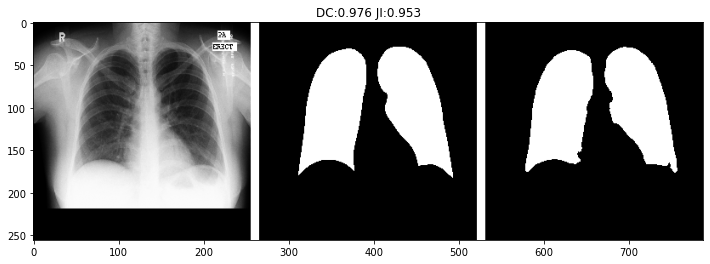

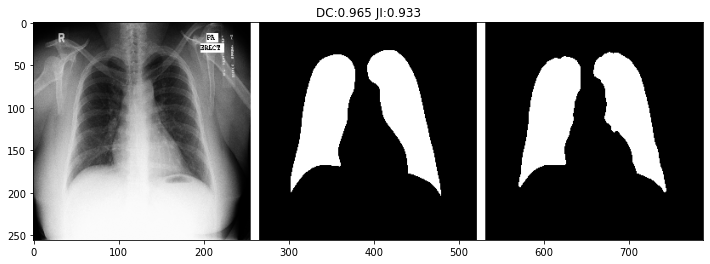

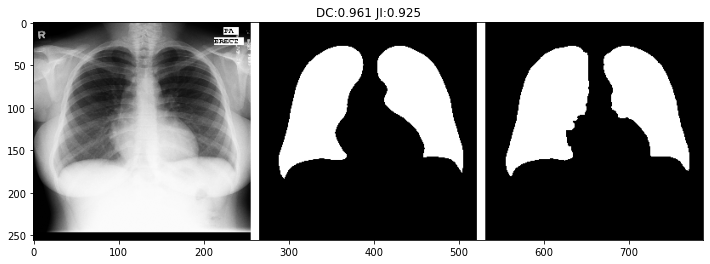

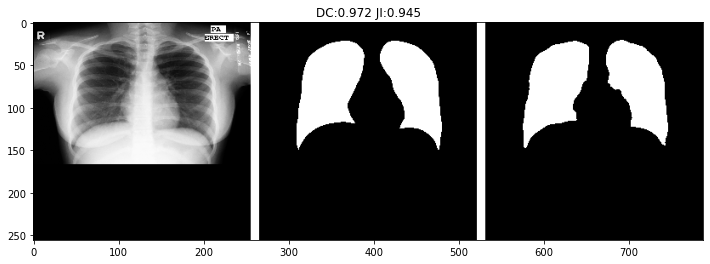

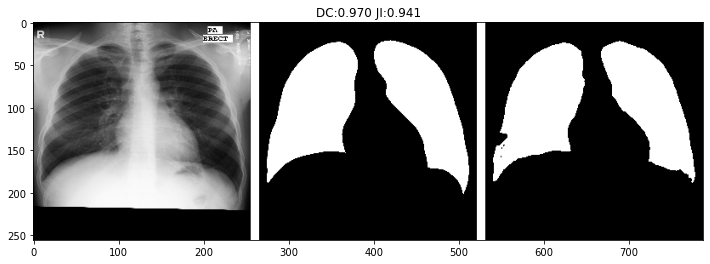

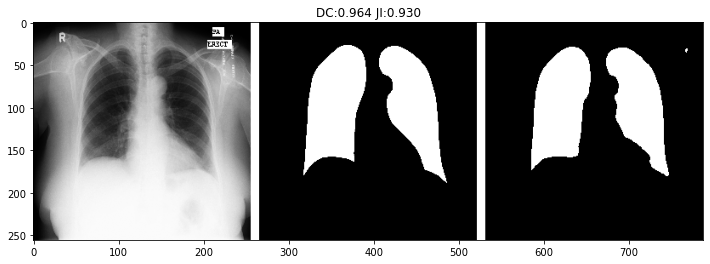

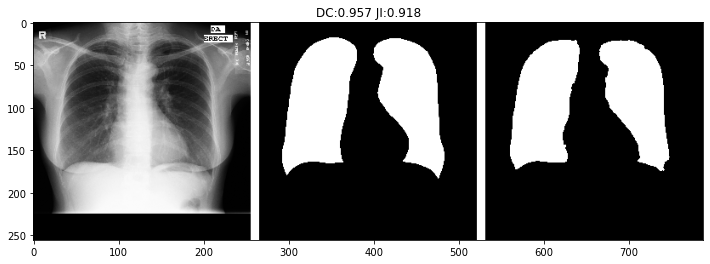

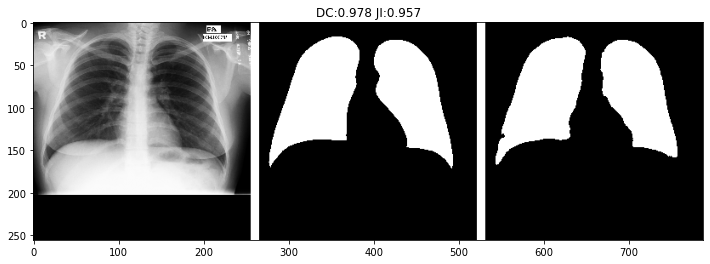

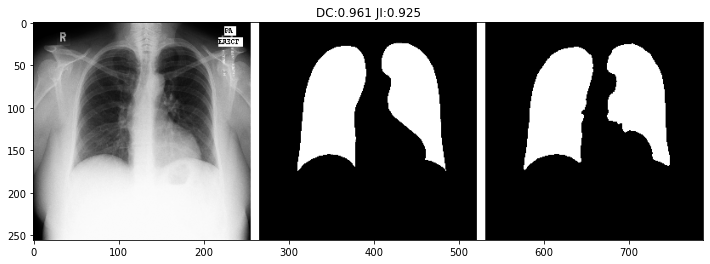

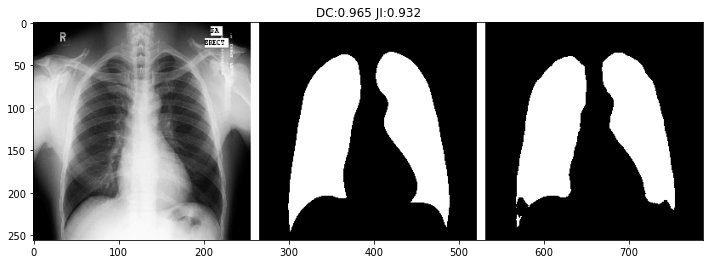

In [91]:
for i, (x, y) in enumerate(zip(test_x[:10], test_y[:10])):
    x = read_image(x)
    y = read_mask(y)
    
    y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
    
    h, w, _ = x.shape
    white_line = np.ones((h, 10, 3))

    all_images = [
        x, white_line,
        mask_parse(y), white_line,
        mask_parse(y_pred)
    ]
    image = np.concatenate(all_images, axis=1)
    
    yp = np.where(y_pred == True, 1.0, 0.0)
    fig = plt.figure(figsize=(12, 12)) 
    a = fig.add_subplot(1, 1, 1)
    a.axes.set_title('DC:{:.3f} JI:{:.3f}'.format(dice_coef(y,yp),jackard_index(y,yp)))
    imgplot = plt.imshow(image)
    
    

In [105]:
dicecoef=0
jackardindex=0
for i, (x, y) in enumerate(zip(test_x, test_y)):
    x = read_image(x)
    y = read_mask(y)
    y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
    yp = np.where(y_pred == True, 1.0, 0.0)
    

    dicecoef += dice_coef(y,yp)
    jackardindex += jackard_index(y,yp)
    
print('DC:{:.3f} JI:{:.3f}'.format(dicecoef/138,jackardindex/138))

DC:0.964 JI:0.931
